In [5]:
# conn.close()

In [1]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
import pyproj

In [3]:
import folium

In [4]:
import clean_data_functions as cdf

In [5]:
DBNAME = "opportunity_youth"

In [6]:
conn = psycopg2.connect(dbname=DBNAME)

In [7]:
#reproduce provided table
pd.read_sql("SELECT * FROM pums_2017 LIMIT 10;", conn);

In [8]:
#select OY in South King County
QUERY = """
    SELECT *
    FROM pums_2017 ps
    JOIN puma_names_2010 pn
    ON ps.puma = pn.puma
    WHERE pn.puma SIMILAR TO '1161(0|1|2|3|4|5)'
    AND ps.agep >= 16
    AND ps.agep <= 24
    AND ps.sch = '1'
    AND ps.dis = '2'
    AND ps.esr SIMILAR TO '%(3|6)%'
    ORDER BY pn
    """
db_south = pd.read_sql(QUERY, conn)
db_south

,rt,serialno,division,sporder,puma,region,st,adjinc,pwgtp,agep,...,pwgtp78,pwgtp79,pwgtp80,state_fips,state_name,cpuma0010,puma,geoid,gisjoin,puma_name
0,P,2013000059060,9,02,11610,4,53,1061971,19.0,22.0,...,15.0,17.0,5.0,53,Washington ...,1044,11610,5311610,G53011610,"King County (Central)--Renton City, Fairwood, ..."
1,P,2014000964654,9,03,11610,4,53,1045195,12.0,24.0,...,14.0,14.0,15.0,53,Washington ...,1044,11610,5311610,G53011610,"King County (Central)--Renton City, Fairwood, ..."
2,P,2013000413288,9,03,11610,4,53,1061971,38.0,18.0,...,31.0,63.0,38.0,53,Washington ...,1044,11610,5311610,G53011610,"King County (Central)--Renton City, Fairwood, ..."
3,P,2017000148009,9,04,11610,4,53,1011189,7.0,18.0,...,2.0,6.0,3.0,53,Washington ...,1044,11610,5311610,G53011610,"King County (Central)--Renton City, Fairwood, ..."
4,P,2013000111689,9,05,11610,4,53,1061971,40.0,19.0,...,52.0,32.0,36.0,53,Washington ...,1044,11610,5311610,G53011610,"King County (Central)--Renton City, Fairwood, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,P,2015001036103,9,02,11612,4,53,1035988,26.0,24.0,...,26.0,41.0,8.0,53,Washington ...,1046,11612,5311612,G53011612,"King County (Far Southwest)--Federal Way, Des ..."
318,P,2014001475081,9,04,11612,4,53,1045195,13.0,22.0,...,12.0,12.0,5.0,53,Washington ...,1046,11612,5311612,G53011612,"King County (Far Southwest)--Federal Way, Des ..."
319,P,2013001447844,9,02,11612,4,53,1061971,23.0,22.0,...,26.0,19.0,23.0,53,Washington ...,1046,11612,5311612,G53011612,"King County (Far Southwest)--Federal Way, Des ..."
320,P,2015000664648,9,03,11612,4,53,1035988,20.0,19.0,...,26.0,17.0,18.0,53,Washington ...,1046,11612,5311612,G53011612,"King County (Far Southwest)--Federal Way, Des ..."


In [9]:
# #load king county data (for mapping underlay/ county outline purposes)
# filename = "../../data/WA_County_Boundaries-shp/WA_County_Boundaries.shp"
# df_WA = gpd.read_file(filename)

In [10]:
# #create geopandas dataframe with geometry from lat/long coordinates (column names case sensitive)
# geo_WA = gpd.GeoDataFrame(df_WA)

In [11]:
# print(geo_WA.crs)

In [12]:
# #find column containing king county
# geo_WA

In [13]:
# geo_king_county = geo_WA.loc[geo_WA['JURISDIC_2']=='King']
# geo_king_county

In [14]:
# ax = geo_WA.plot(color='white', edgecolor='black' )

# fig = geo_king_county.plot(ax=ax, color='red')
# plt.xticks([])
# plt.yticks([])
# plt.title('Counties in WA State (Mercator)', color='white')
# plt.xlabel('King County (in red)', color='white')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# plt.savefig('king_on_WA.png', transparent=True)

In [15]:
# declre df with desired pumas without duplicates from columns
db_south_pumas = db_south['puma'].drop_duplicates()

In [16]:
# remove duplicate column, coonvert topo list of pumas
db_south_pumas = db_south_pumas.loc[:,~db_south_pumas.columns.duplicated()]
pumas = list(db_south_pumas['puma'])
pumas

['11610', '11613', '11614', '11615', '11611', '11612']

In [17]:
# load king county by king county puma data
filename = "../../src/data/shapefiles/tl_2017_53_puma10/tl_2017_53_puma10.shp"
all_pumas_shp = gpd.read_file(filename)
all_pumas_shp.head()

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,53,10200,5310200,"Skagit, Island & San Juan Counties PUMA",G6120,S,5470622131,2441658886,+48.4470835,-122.1737477,"POLYGON ((-122.44422 48.64527, -122.43685 48.6..."
1,53,10100,5310100,Whatcom County--Bellingham City PUMA,G6120,S,5459332804,1028183246,+48.8426531,-121.8364325,"POLYGON ((-122.40642 49.00230, -122.40617 49.0..."
2,53,10400,5310400,"Stevens, Okanogan, Pend Oreille & Ferry Counti...",G6120,S,29389124389,489162432,+48.5031090,-118.7866777,"POLYGON ((-118.14859 47.88667, -118.14899 47.8..."
3,53,10504,5310504,Spokane County (Outer)--Cheney City PUMA,G6120,S,3983412021,35812133,+47.5972847,-117.1210417,"POLYGON ((-117.10528 47.61018, -117.10527 47.6..."
4,53,10503,5310503,Spokane County (East Central)--Greater Spokane...,G6120,S,270926976,5004332,+47.6561281,-117.1818649,"POLYGON ((-117.15534 47.69971, -117.15509 47.6..."


In [18]:
# convert pumas column to int
all_pumas_shp.PUMACE10 = all_pumas_shp.PUMACE10.astype('int64')

In [19]:
south_king_shp = all_pumas_shp[all_pumas_shp.PUMACE10.between(11610,11615)]

In [20]:
south_king_shp

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
9,53,11612,5311612,"King County (Far Southwest)--Federal Way, Des ...",G6120,S,160638807,279665546,+47.4764651,-122.4271168,"POLYGON ((-122.33587 47.26382, -122.33676 47.2..."
35,53,11611,5311611,"King County (West Central)--Burien, SeaTac, Tu...",G6120,S,104685305,6835973,+47.4500687,-122.3101564,"POLYGON ((-122.26541 47.48933, -122.26516 47.4..."
41,53,11615,5311615,"King County (Southeast)--Maple Valley, Covingt...",G6120,S,1704963276,21281417,+47.2986756,-121.7866429,"POLYGON ((-121.99603 47.28012, -121.99615 47.2..."
42,53,11614,5311614,King County (Southwest)--Auburn City & Lakelan...,G6120,S,177945706,2750138,+47.2844346,-122.1690701,"POLYGON ((-122.21930 47.25746, -122.21948 47.2..."
44,53,11613,5311613,King County (Southwest Central)--Kent City PUMA,G6120,S,96646675,1914377,+47.3879703,-122.2127275,"POLYGON ((-122.20242 47.34461, -122.20287 47.3..."
52,53,11610,5311610,"King County (Central)--Renton City, Fairwood, ...",G6120,S,75931302,4694856,+47.4836108,-122.1904418,"POLYGON ((-122.18399 47.51673, -122.18361 47.5..."


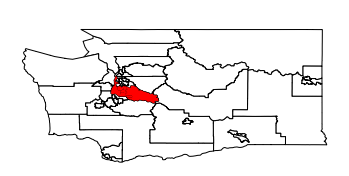

In [21]:
ax = all_pumas_shp.plot(color='white', edgecolor='black' )
fig = south_king_shp.plot(ax=ax, color='red')
plt.xticks([])
plt.yticks([])
plt.title('Location of South King County', color='white')
plt.xlabel('South King County (in red)', color='white')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.axis('off')
plt.savefig('south_king_on_WA.png', transparent=True)

In [22]:
#define new gdf with only king county shp info
king_pumas_shp = all_pumas_shp[(all_pumas_shp.PUMACE10.between(11601, 11616))]

In [23]:
res_union = gpd.overlay(all_pumas_shp, king_pumas_shp, how='intersection')

(-125.24561915, -116.51942585, 45.37059645, 49.175376549999996)

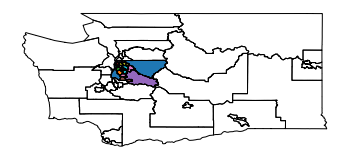

In [24]:
ax = res_union.plot(alpha=1, cmap='tab10')
all_pumas_shp.plot(ax=ax, facecolor='none', edgecolor='k')
king_pumas_shp.plot(ax=ax, facecolor='none', edgecolor='k')
ax.axis('off')

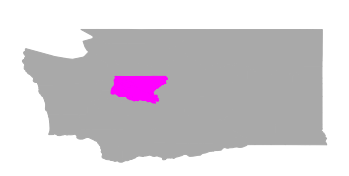

In [25]:
ax = all_pumas_shp.plot(color='darkgray', edgecolor='darkgrey', zorder=0 )
fig = king_pumas_shp.plot(ax=ax, color='fuchsia', edgecolor='fuchsia', zorder=1 )
plt.xticks([])
plt.yticks([])
plt.title('King County', color='white')
plt.xlabel('King County', color='white')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.axis('off')
plt.savefig('king_on_WA.png', transparent=True)

In [26]:
res_union = gpd.overlay(south_king_shp, king_pumas_shp, how='intersection')

In [27]:
list(south_king_shp.NAMELSAD10)

['King County (Far Southwest)--Federal Way, Des Moines Cities & Vashon Island PUMA',
 'King County (West Central)--Burien, SeaTac, Tukwila Cities & White Center PUMA',
 'King County (Southeast)--Maple Valley, Covington & Enumclaw Cities PUMA',
 'King County (Southwest)--Auburn City & Lakeland PUMA',
 'King County (Southwest Central)--Kent City PUMA',
 'King County (Central)--Renton City, Fairwood, Bryn Mawr & Skyway PUMA']

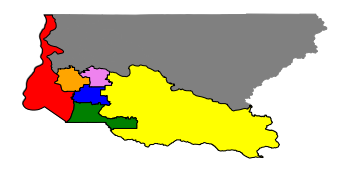

In [38]:
ax = king_pumas_shp.plot(alpha=1, facecolor='grey', edgecolor='grey')

labels = []
plots = []
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']

for i in range(len(south_king_shp)):
    row_entry = gpd.GeoDataFrame(south_king_shp.iloc[i]).transpose()
    region_name = row_entry.NAMELSAD10.iloc[0]
    labels.append(region_name)
    row_entry.plot(ax=ax, facecolor=colors[i], edgecolor='k', zorder=1, label="1")
    plots.append(row_entry)


# legend_lines = []

# for i in range(len(colors)):
    
#     legend_lines.append([Line2D([0], [0], color=colors[i], lw=4)])

# ax.legend(legend_lines, 'labels')
    
    
# color_label = mpatches.Patch(color=colors, label=labels)    
# ax.legend(handles=[color_label])

# ax.legend(colors, labels)
# ax.legend(colors, labels)
# ax.legend(plots, region_name)
# ax.legend(plots, colors)
# plt.show()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axis('off');

In [76]:
ax = res_union.plot(alpha=1, cmap='tab10')
south_king_shp.plot(ax=ax, facecolor='none', edgecolor='k', zorder=1)
king_pumas_shp.plot(ax=ax, facecolor='grey', edgecolor='grey', zorder=0)
ax.axis('off');

In [28]:
# get dict from teammate defined function
oy_count_dict = cdf.get_pums_oy_count()

In [29]:
# create list to change to pandas friendly format
oy_count_list = [[x for x in oy_count_dict.keys()],[x for x in oy_count_dict.values()]]


In [30]:
# create list to change to pandas friendly format
oy_df_dict = {'total': oy_count_list[1], 'puma': oy_count_list[0]}

In [31]:
oy_df_dict

{'total': [1853.0, 2038.0, 1977.0, 2006.0, 1530.0, 1210.0],
 'puma': ['11610', '11611', '11612', '11613', '11614', '11615']}

In [32]:
# finally, create dataframe
df_oy = pd.DataFrame.from_dict(oy_df_dict)
df_oy.puma = df_oy.puma.astype('int64')
df_oy

,total,puma
0,1853.0,11610
1,2038.0,11611
2,1977.0,11612
3,2006.0,11613
4,1530.0,11614
5,1210.0,11615


In [33]:
# create merged dataframe for choro
# merged = south_king_shp.set_index('PUMACE10').join(df_oy.set_index('puma'))  #stopped working after reset kernel
merged = south_king_shp.merge(df_oy, left_on=south_king_shp.PUMACE10, right_on=df_oy.puma)
merged

,key_0,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,total,puma
0,11612,53,11612,5311612,"King County (Far Southwest)--Federal Way, Des ...",G6120,S,160638807,279665546,+47.4764651,-122.4271168,"POLYGON ((-122.33587 47.26382, -122.33676 47.2...",1977.0,11612
1,11611,53,11611,5311611,"King County (West Central)--Burien, SeaTac, Tu...",G6120,S,104685305,6835973,+47.4500687,-122.3101564,"POLYGON ((-122.26541 47.48933, -122.26516 47.4...",2038.0,11611
2,11615,53,11615,5311615,"King County (Southeast)--Maple Valley, Covingt...",G6120,S,1704963276,21281417,+47.2986756,-121.7866429,"POLYGON ((-121.99603 47.28012, -121.99615 47.2...",1210.0,11615
3,11614,53,11614,5311614,King County (Southwest)--Auburn City & Lakelan...,G6120,S,177945706,2750138,+47.2844346,-122.1690701,"POLYGON ((-122.21930 47.25746, -122.21948 47.2...",1530.0,11614
4,11613,53,11613,5311613,King County (Southwest Central)--Kent City PUMA,G6120,S,96646675,1914377,+47.3879703,-122.2127275,"POLYGON ((-122.20242 47.34461, -122.20287 47.3...",2006.0,11613
5,11610,53,11610,5311610,"King County (Central)--Renton City, Fairwood, ...",G6120,S,75931302,4694856,+47.4836108,-122.1904418,"POLYGON ((-122.18399 47.51673, -122.18361 47.5...",1853.0,11610


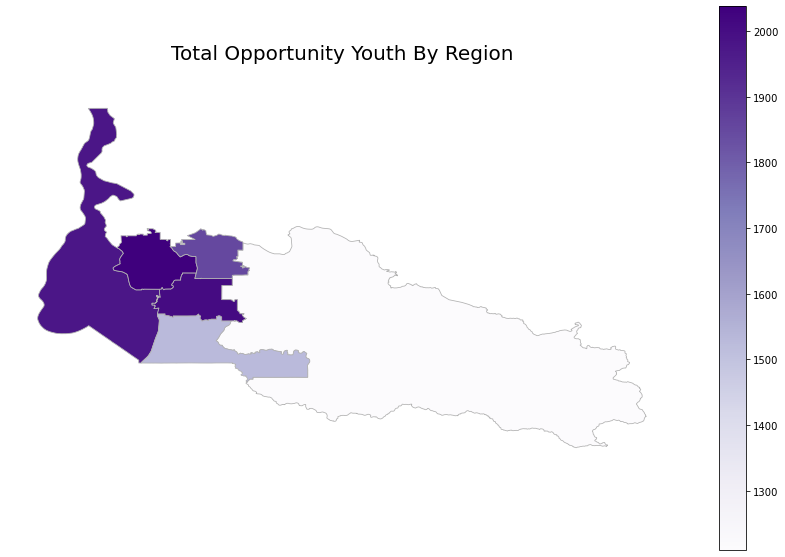

In [43]:
# define column name for choro index
variable = 'total'
# define range for choro intensities/alphas
vmin, vmax = min(oy_count_dict.values()), max(oy_count_dict.values())

fig, ax = plt.subplots(1, figsize=(15,10))

# choose styles for easy modification

cmap='Purples'

merged.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.7')
ax.axis('off')
# give title and extra space above map
plt.title('Total Opportunity Youth By Region', fontsize=20, y=1.07)


# create choro legend
sm = plt.cm.ScalarMappable(cmap=cmap,
norm=plt.Normalize(vmin=vmin, vmax=vmax))

cbar = fig.colorbar(sm)
fig.savefig('choropleth_total_oy_by_region.png', transparent=True)

In [35]:
#hover trace
hover_scatter = [scatt for scatt in fig.data if scatt.mode == 'markers'][0]

import re
def extract_name(text_val):
    return re.sub(r'PUMACE10: (.*?)<br>.*', r'\1', text_val)

hover_scatter.text = [extract_name(text_val) for text_val in hover_scatter.text]
                      
hoverscatter.mode = 'markers+text'

hover_scatter.textfont.size = 8



AttributeError: 'Figure' object has no attribute 'data'

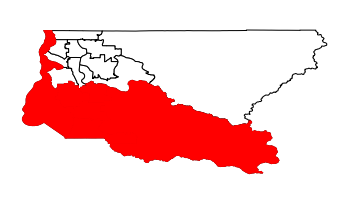

In [44]:
ax = king_pumas_shp.plot(color='white', edgecolor='black' )
fig = south_king_shp.plot(ax=ax, color='red', edgecolor='red')
plt.xticks([])
plt.yticks([])
plt.title('South King County', color='white')
plt.xlabel('South King County (in red)', color='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('south_king_on_king.png', transparent=True)

In [36]:
# folium parameters
lat = 47.6062
long = -122.3321
DFW_Map = folium.Map(location=[lat, long], zoom_start=10)

In [37]:
# location_marker = folium.map.FeatureGroup()
# latitudes = list(df.LAT)
# longitudes = list(df.LONG)
# labels = list(fa.EVENT_TYPE)

# for lat, long, label in zip(latitused, longitudes, labels):
#     if label == 'WHAT IS MY LABEL????????':
#         folium.Marker(
#             location = [lat, long],
#             popup=label,
#             icon=folium.Icon(color='red', icon='info-sign')# change icon******
#         ).add_to(DFW_Map)
#     else:
#         folium.Marker(
#             location = [lat, long],
#             popup=label,
#             icon=folium.Icon(color='green', icon='info-sign')# change icon******
#         ).add_to(DFW_Map)

In [38]:
# DFW_Map.add_child(location_marker) #location marker form above, folium.FeatureGroup()
# DFW_Map

In [ ]:
#conn.close()